In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import glob
import numpy as np
import pandas as pd

In [3]:
# directory path
base_dir = os.path.join("/content/drive/My Drive/malaria_detection/cell_images")
infected_dir = os.path.join(base_dir, "Parasitized")
helthy_dir = os.path.join(base_dir, "Uninfected")

# get iamges
infected_files = glob.glob(infected_dir+'/*.png')
helthy_files = glob.glob(helthy_dir+'/*.png')

len(infected_files), len(helthy_files)

(13799, 13789)

In [4]:
np.random.seed(42)

df = pd.DataFrame({
    "filename": infected_files + helthy_files,
    "labels": ["malaria"]*len(infected_files) + ["helthy"]*len(helthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,filename,labels
0,/content/drive/My Drive/malaria_detection/cell...,malaria
1,/content/drive/My Drive/malaria_detection/cell...,helthy
2,/content/drive/My Drive/malaria_detection/cell...,helthy
3,/content/drive/My Drive/malaria_detection/cell...,malaria
4,/content/drive/My Drive/malaria_detection/cell...,malaria


# Build a dataset

In [0]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df["filename"].values,
                                                    df["labels"].values, test_size=0.3, random_state=42)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [8]:
print(X_train.shape, X_test.shape, X_val.shape)
print("train:", Counter(Y_train), "\nVal:", Counter(Y_val), "\nTest:", Counter(Y_test))

(17379,) (8277,) (1932,)
train: Counter({'malaria': 8725, 'helthy': 8654}) 
Val: Counter({'helthy': 998, 'malaria': 934}) 
Test: Counter({'malaria': 4140, 'helthy': 4137})


In [9]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (125, 125)

def get_image_shape(idx, image, total_img):
    if idx % 5000 == 0 or  idx  == (total_img - 1):
        print("{}: working on img num: {}".format(threading.current_thread().name, idx))
    
    img = cv2.imread(image)
    img = cv2.resize(img, IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    
    img =  np.array(img, dtype=np.float32)
    return img
    

# parallel processing
ex = futures.ThreadPoolExecutor(max_workers=None)

train_data_input = [(idx, img, len(X_train)) for idx, img in enumerate(X_train)]
test_data_input = [(idx, img, len(X_test)) for idx, img in enumerate(X_test)]
val_data_input = [(idx, img, len(X_val)) for idx, img in enumerate(X_val)]

# train data load
train_dim_map = ex.map(get_image_shape,
                       [record[0] for record in train_data_input],
                       [record[1] for record in train_data_input],
                       [record[2] for record in train_data_input]
                      )

train_data = np.array(list(train_dim_map))

# test data load
test_dim_map = ex.map(get_image_shape,
                       [record[0] for record in test_data_input],
                       [record[1] for record in test_data_input],
                       [record[2] for record in test_data_input]
                      )

test_data = np.array(list(test_dim_map))

# validation data load
val_dim_map = ex.map(get_image_shape,
                       [record[0] for record in val_data_input],
                       [record[1] for record in val_data_input],
                       [record[2] for record in val_data_input]
                      )

val_data = np.array(list(val_dim_map))

train_data.shape, test_data.shape, val_data.shape

ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_16: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 10000
ThreadPoolExecutor-0_0: working on img num: 15000
ThreadPoolExecutor-0_14: working on img num: 17378
ThreadPoolExecutor-0_8: working on img num: 0
ThreadPoolExecutor-0_14: working on img num: 5000
ThreadPoolExecutor-0_16: working on img num: 8276
ThreadPoolExecutor-0_2: working on img num: 0
ThreadPoolExecutor-0_13: working on img num: 1931


((17379, 125, 125, 3), (8277, 125, 125, 3), (1932, 125, 125, 3))

**leverage parallel proccesing to speed up computation pertaining to image load and resize**

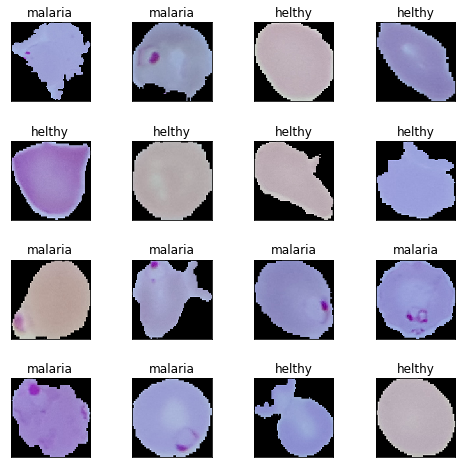

In [10]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(8, 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0, train_data.shape[0], 1 )
    plt.subplot(4, 4, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title("{}".format(Y_train[r[0]]))
    plt.xticks([]) , plt.yticks([])

# configuration settings.

In [11]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 5
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_image_scaled = val_data /255.

# encode label 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(Y_train)
train_label = le.transform(Y_train)

print(Y_train[:3], train_label[:3])

['malaria' 'helthy' 'malaria'] [1 0 1]


In [12]:
val_labels = le.transform(Y_val)
print(Y_val[:5], val_labels[:5])

['helthy' 'helthy' 'helthy' 'malaria' 'malaria'] [0 0 0 1 1]


In [1]:
import tensorflow as tf

# load tensorboard
%load_ext tensorboard

tf.__version__

'2.1.0'

# model training

**CNN**

In [13]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                              activation="relu", padding="same")(inp)

pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                              activation="relu", padding="same")(pool1)

pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                              activation="relu", padding="same")(pool2)

pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation="relu")(flat)
drop1 = tf.keras.layers.Dropout(0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation="relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.3)(hidden2)

output = tf.keras.layers.Dense(1, activation="sigmoid")(drop2)
 
model  = tf.keras.Model(inputs=inp, outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [14]:
import datetime

logdir = os.path.join("tensorboard_logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                                 patience=2, min_lr=0.00001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_data, y=train_label, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_data, val_labels),
                    callbacks=callbacks,
                    verbose=1)

Train on 17379 samples, validate on 1932 samples
Epoch 1/5
17379/17379 [==============================] - 11s 608us/sample - loss: 2.4146 - accuracy: 0.6003 - val_loss: 0.6427 - val_accuracy: 0.6408
Epoch 2/5
17379/17379 [==============================] - 8s 471us/sample - loss: 0.6248 - accuracy: 0.6595 - val_loss: 0.6288 - val_accuracy: 0.6387
Epoch 3/5
17379/17379 [==============================] - 8s 472us/sample - loss: 0.5772 - accuracy: 0.6976 - val_loss: 0.6411 - val_accuracy: 0.6341
Epoch 4/5
17379/17379 [==============================] - 8s 471us/sample - loss: 0.5102 - accuracy: 0.7436 - val_loss: 0.6728 - val_accuracy: 0.6532
Epoch 5/5
17379/17379 [==============================] - 8s 468us/sample - loss: 0.3866 - accuracy: 0.8228 - val_loss: 0.7509 - val_accuracy: 0.6346


**model looks to be overfitting**

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

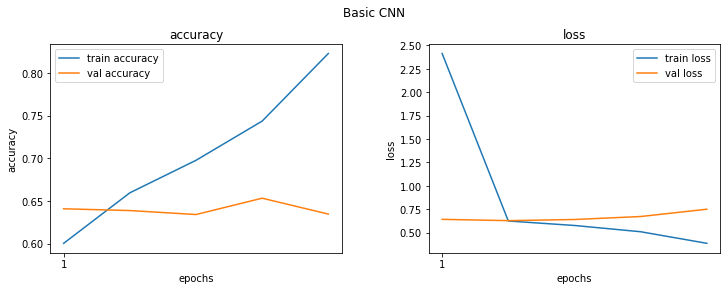

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
titile = f.suptitle("Basic CNN", fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epochs = len(history.history["accuracy"])+1
epochs_list = list(range(1, max_epochs))

ax1.plot(epochs_list, history.history["accuracy"], label="train accuracy")
ax1.plot(epochs_list, history.history["val_accuracy"], label="val accuracy")
ax1.set_xticks(np.arange(1, max_epochs, 5))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
l1 = ax1.legend(loc="best")


ax2.plot(epochs_list, history.history["loss"], label="train loss")
ax2.plot(epochs_list, history.history["val_loss"], label="val loss")
ax2.set_xticks(np.arange(1, max_epochs, 5))
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")
ax2.set_title("loss")
l2 = ax2.legend(loc="best")

plt.show()

In [0]:
# save  model
model.save('basic_cnn.h5')

# Deep transfer learning

**Pre-trained model as a feature extractor**

freeze the convolution blocks so we can use them as an image feature extractor. We will plug in our own dense layers at the end to perform the classification task.

In [18]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",
                                        input_shape=INPUT_SHAPE)

vgg.trainable = False

# freez layers
for layer in vgg.layers:
  layer.trainable = False

base_vgg = vgg
base_output = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_output)
hidden1 = tf.keras.layers.Dense(512, activation="relu")(pool_out)
drop1 = tf.keras.layers.Dropout(0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation="relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.3)(hidden2)

output = tf.keras.layers.Dense(1, activation="sigmoid")(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [19]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:",
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_data, y=train_label, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_data, val_labels),
                    callbacks=callbacks,
                    verbose=1)

Train on 17379 samples, validate on 1932 samples
Epoch 1/5
17379/17379 [==============================] - 22s 1ms/sample - loss: 0.7790 - accuracy: 0.8427 - val_loss: 0.2723 - val_accuracy: 0.9094
Epoch 2/5
17379/17379 [==============================] - 20s 1ms/sample - loss: 0.3411 - accuracy: 0.8954 - val_loss: 0.2125 - val_accuracy: 0.9286
Epoch 3/5
17379/17379 [==============================] - 20s 1ms/sample - loss: 0.2572 - accuracy: 0.9151 - val_loss: 0.2327 - val_accuracy: 0.9260
Epoch 4/5
17379/17379 [==============================] - 20s 1ms/sample - loss: 0.2142 - accuracy: 0.9294 - val_loss: 0.2152 - val_accuracy: 0.9296
Epoch 5/5
17379/17379 [==============================] - 20s 1ms/sample - loss: 0.1644 - accuracy: 0.9433 - val_loss: 0.2177 - val_accuracy: 0.9379


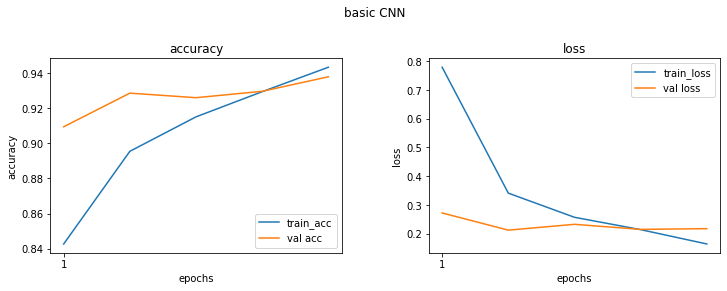

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
title = f.suptitle("basic CNN", fontsize=12)
f.subplots_adjust(top=0.8, wspace=0.3)

max_epoch = len(history.history["accuracy"])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history["accuracy"], label="train_acc")
ax1.plot(epochs_list, history.history["val_accuracy"], label="val acc")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
l1 = ax1.legend(loc="best")

ax2.plot(epochs_list, history.history["loss"], label="train_loss")
ax2.plot(epochs_list, history.history["val_loss"], label="val loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.set_title("loss")
l2 = ax2.legend(loc="best")

In [0]:
model.save('vgg_frozen.h5')

**Fine-tuned pre-trained model with image augmentation**

will fine-tune the weights of the layers in the last two blocks of our pre-trained VGG-19 model

The idea behind image augmentation is exactly as the name sounds. We load in existing images from our training dataset and apply some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, to produce new, altered versions of existing images. Due to these random transformations, we don't get the same images each time.



# Build image agumentor

In [0]:
# ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                            zoom_range=0.05,
                                                            rotation_range=25,
                                                            width_shift_range=0.05,
                                                            height_shift_range=0.05,
                                                            shear_range=0.05, horizontal_flip=True,
                                                            fill_mode="nearest")

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# build image agumentation generator
train_gen = train_datagen.flow(train_data, train_label, batch_size=BATCH_SIZE, shuffle=True)
val_gen = train_datagen.flow(val_data, val_labels, batch_size=BATCH_SIZE, shuffle=True)

Labels: [1, 1, 1, 1, 1]


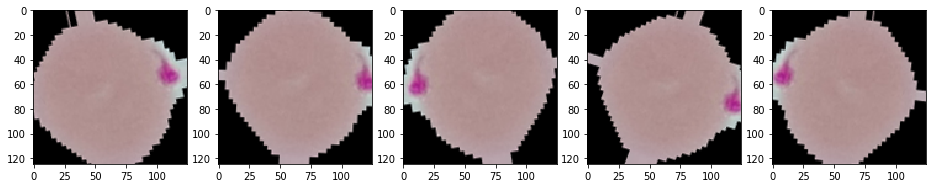

In [27]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_label[img_id: img_id+1], batch_size=1)

sample = [next(sample_generator) for i in range(0, 5)]
fig, ax = plt.subplots(1, 5, figsize=(16, 6))
print("Labels:", [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in  range(0, 5)]

In [28]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",
                                       input_shape=INPUT_SHAPE)

vgg.trainable=False
set_trainable = False

for layer in vgg.layers:
  if layer.name in ["block5_conv1", "block4_conv1"]:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_gen.n // train_gen.batch_size
val_steps_per_epoch = val_gen.n // val_gen.batch_size
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/5
271/271 [==============================] - 70s 258ms/step - loss: 0.2450 - accuracy: 0.8982 - val_loss: 0.1412 - val_accuracy: 0.9542
Epoch 2/5
271/271 [==============================] - 68s 251ms/step - loss: 0.1406 - accuracy: 0.9525 - val_loss: 0.1354 - val_accuracy: 0.9568
Epoch 3/5
271/271 [==============================] - 68s 250ms/step - loss: 0.1264 - accuracy: 0.9547 - val_loss: 0.1169 - val_accuracy: 0.9630
Epoch 4/5
271/271 [==============================] - 68s 249ms/step - loss: 0.1177 - accuracy: 0.9585 - val_loss: 0.1121 - val_accuracy: 0.9661
Epoch 5/5
271/271 [==============================] - 68s 252ms/step - loss: 0.1095 - accuracy: 0.9612 - val_loss: 0.1152 - val_accuracy: 0.9625


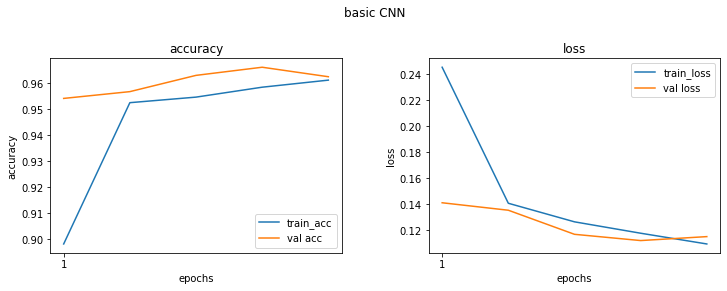

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
title = f.suptitle("basic CNN", fontsize=12)
f.subplots_adjust(top=0.8, wspace=0.3)

max_epoch = len(history.history["accuracy"])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history["accuracy"], label="train_acc")
ax1.plot(epochs_list, history.history["val_accuracy"], label="val acc")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
l1 = ax1.legend(loc="best")

ax2.plot(epochs_list, history.history["loss"], label="train_loss")
ax2.plot(epochs_list, history.history["val_loss"], label="val loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.set_title("loss")
l2 = ax2.legend(loc="best")

In [0]:
model.save('vgg_finetuned.h5')

# evaluation

In [33]:
test_img_scale = test_data / 255.
test_img_scale.shape, Y_test.shape

((8277, 125, 125, 3), (8277,))

In [0]:
# load model
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

# make prediction
basic_cnn_pred = basic_cnn.predict(test_img_scale, batch_size=512)
vgg_frz_pred = vgg_frz.predict(test_img_scale, batch_size=512)
vgg_ft_pred = vgg_ft.predict(test_img_scale, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in basic_cnn_pred.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in vgg_frz_pred.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in vgg_ft_pred.ravel()])

In [39]:
from sklearn import metrics
import pandas as pd

basic_cnn_metrics = {}
vgg_frz_metrics = {}
vgg_ft_metrics = {}
basic_cnn_metrics["Accuracy"] = np.round(metrics.accuracy_score(Y_test, basic_cnn_pred_labels), 4)
vgg_frz_metrics["Accuracy"] = np.round(metrics.accuracy_score(Y_test, vgg_frz_pred_labels), 4)
vgg_ft_metrics["Accuracy"] = np.round(metrics.accuracy_score(Y_test, vgg_ft_pred_labels), 4)

basic_cnn_metrics["Precision"] = np.round(metrics.precision_score(Y_test, basic_cnn_pred_labels, average='weighted'), 4)
vgg_frz_metrics["Precision"] = np.round(metrics.precision_score(Y_test, vgg_frz_pred_labels, average='weighted'), 4)
vgg_ft_metrics["Precision"] = np.round(metrics.precision_score(Y_test, vgg_ft_pred_labels, average='weighted'), 4)

basic_cnn_metrics["Recall"] = np.round(metrics.recall_score(Y_test, basic_cnn_pred_labels, average='weighted'), 4)
vgg_frz_metrics["Recall"] = np.round(metrics.recall_score(Y_test, vgg_frz_pred_labels, average='weighted'), 4)
vgg_ft_metrics["Recall"] = np.round(metrics.recall_score(Y_test, vgg_ft_pred_labels, average='weighted'), 4)
 
basic_cnn_metrics["F1_score"] = np.round(metrics.f1_score(Y_test, basic_cnn_pred_labels, average='weighted'), 4)
vgg_frz_metrics["F1_score"] = np.round(metrics.f1_score(Y_test, vgg_frz_pred_labels, average='weighted'), 4)
vgg_ft_metrics["F1_score"] = np.round(metrics.f1_score(Y_test, vgg_ft_pred_labels, average='weighted'), 4)


pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics],
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1_score
Basic CNN,0.5002,0.2502,0.5002,0.3335
VGG-19 Frozen,0.6836,0.7713,0.6836,0.6558
VGG-19 Fine-tuned,0.9588,0.9598,0.9588,0.9588
